In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Read Benchmark Data

In [2]:
benchmark_results_path = "../results/"
data = []
for root, dirs, files in os.walk(benchmark_results_path):
    for file in files:
        if file.endswith(".csv"):
            df_ = pd.read_csv(os.path.join(root, file))
            data.append(df_)

df = pd.concat(data)

In [3]:
df.head()

,model_name,env_id,prompt_chain,temperature,context_length,episode_reward,episode_length
0,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,simple,0.01,0,5.0,710
1,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,simple,0.01,0,0.0,690
2,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,simple,0.01,0,5.0,711
3,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,simple,0.01,0,5.0,594
4,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,simple,0.01,0,0.0,686


### Aggregate Results for each Benchmark run

In [4]:
df['mean_reward'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length'])['episode_reward'].transform('mean')
df['std_reward'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length'])['episode_reward'].transform('std')
df['mean_length'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length'])['episode_length'].transform('mean')
df['std_length'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length'])['episode_length'].transform('std')

### Plot

/tmp/ipykernel_870780/2245138313.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['mean_reward'] = df_['mean_reward'].replace(0, 1)
/tmp/ipykernel_870780/2245138313.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['mean_reward'] = df_['mean_reward'].replace(0, 1)


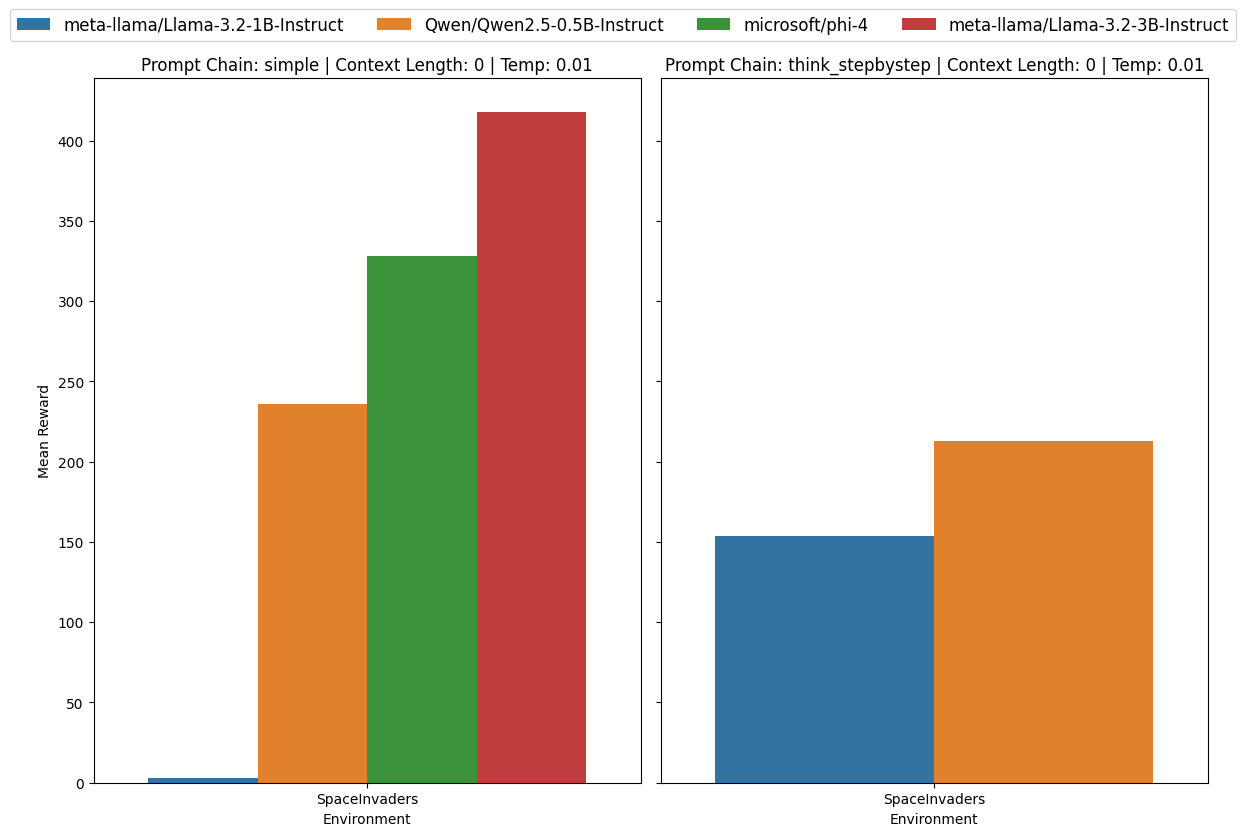

/tmp/ipykernel_870780/2245138313.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['mean_reward'] = df_['mean_reward'].replace(0, 1)
/tmp/ipykernel_870780/2245138313.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['mean_reward'] = df_['mean_reward'].replace(0, 1)


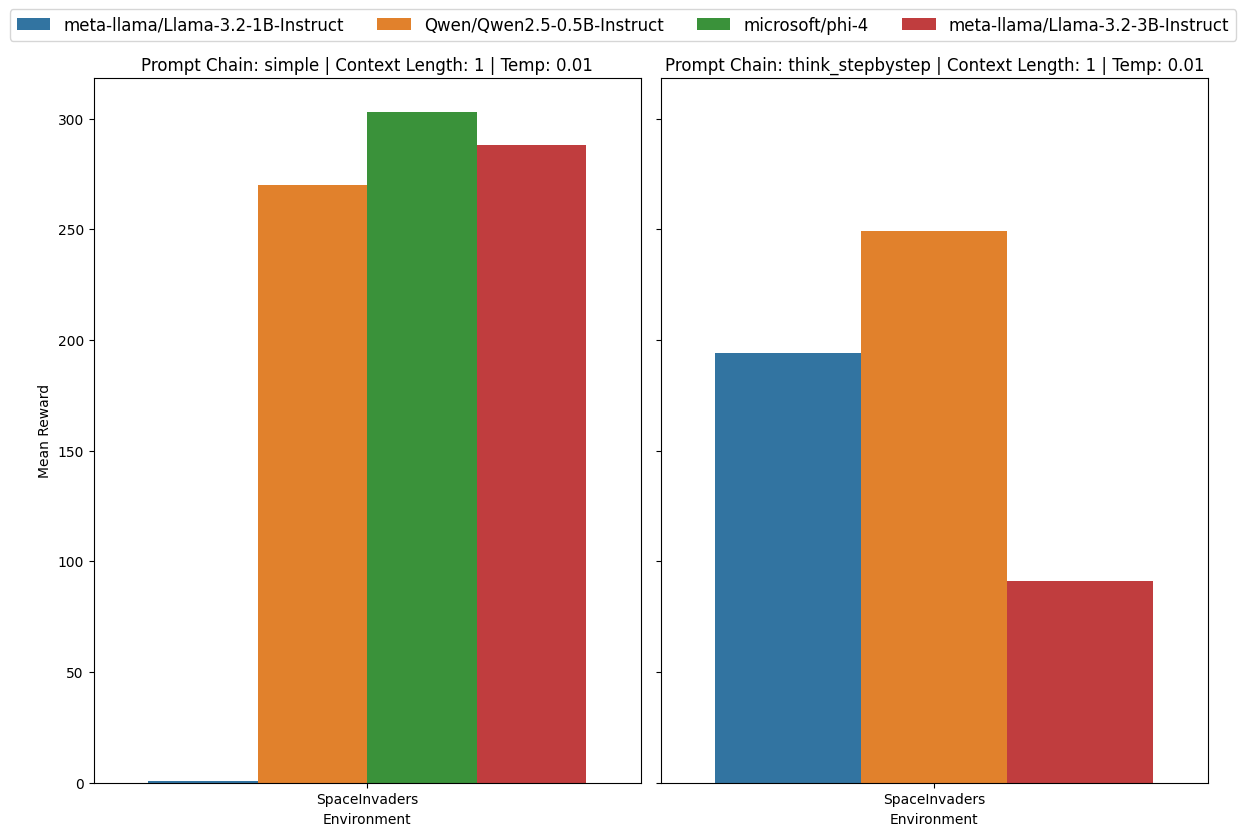

/tmp/ipykernel_870780/2245138313.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['mean_reward'] = df_['mean_reward'].replace(0, 1)
/tmp/ipykernel_870780/2245138313.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['mean_reward'] = df_['mean_reward'].replace(0, 1)


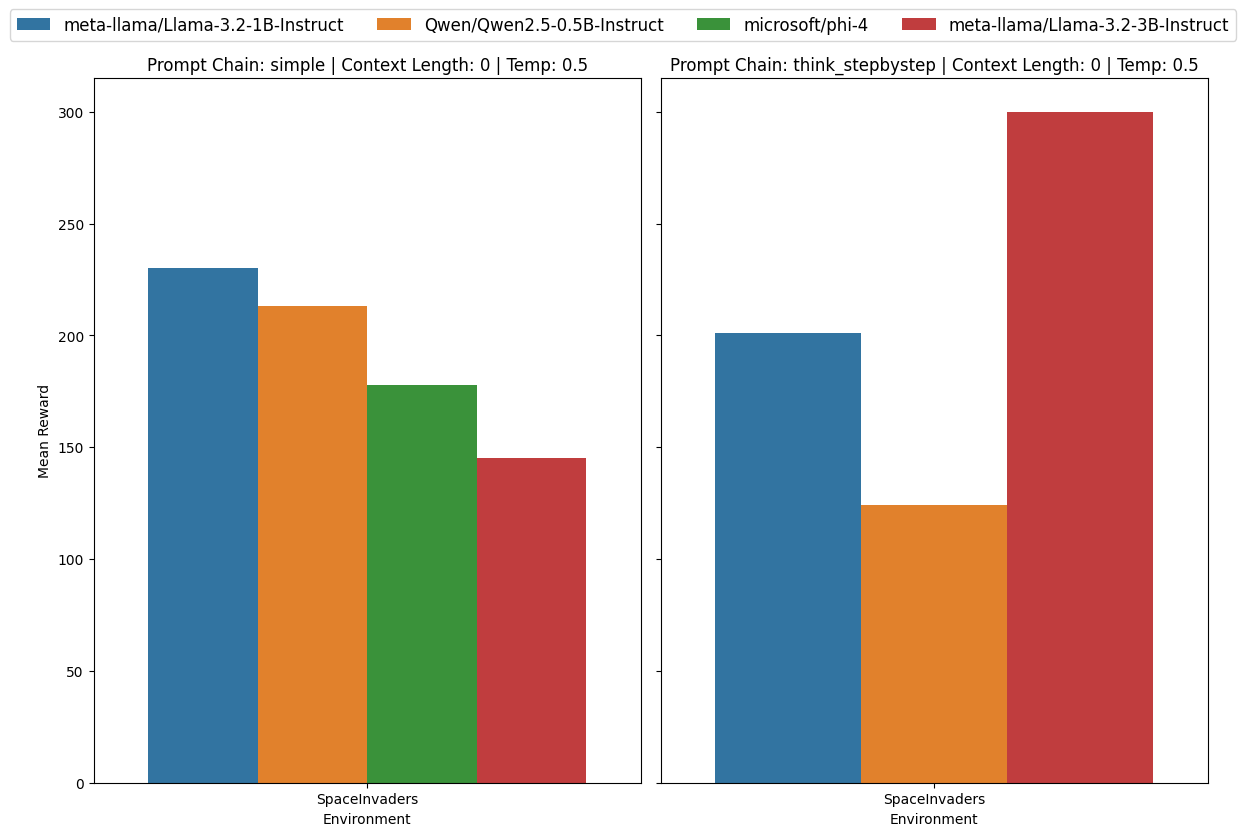

/tmp/ipykernel_870780/2245138313.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['mean_reward'] = df_['mean_reward'].replace(0, 1)
/tmp/ipykernel_870780/2245138313.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['mean_reward'] = df_['mean_reward'].replace(0, 1)


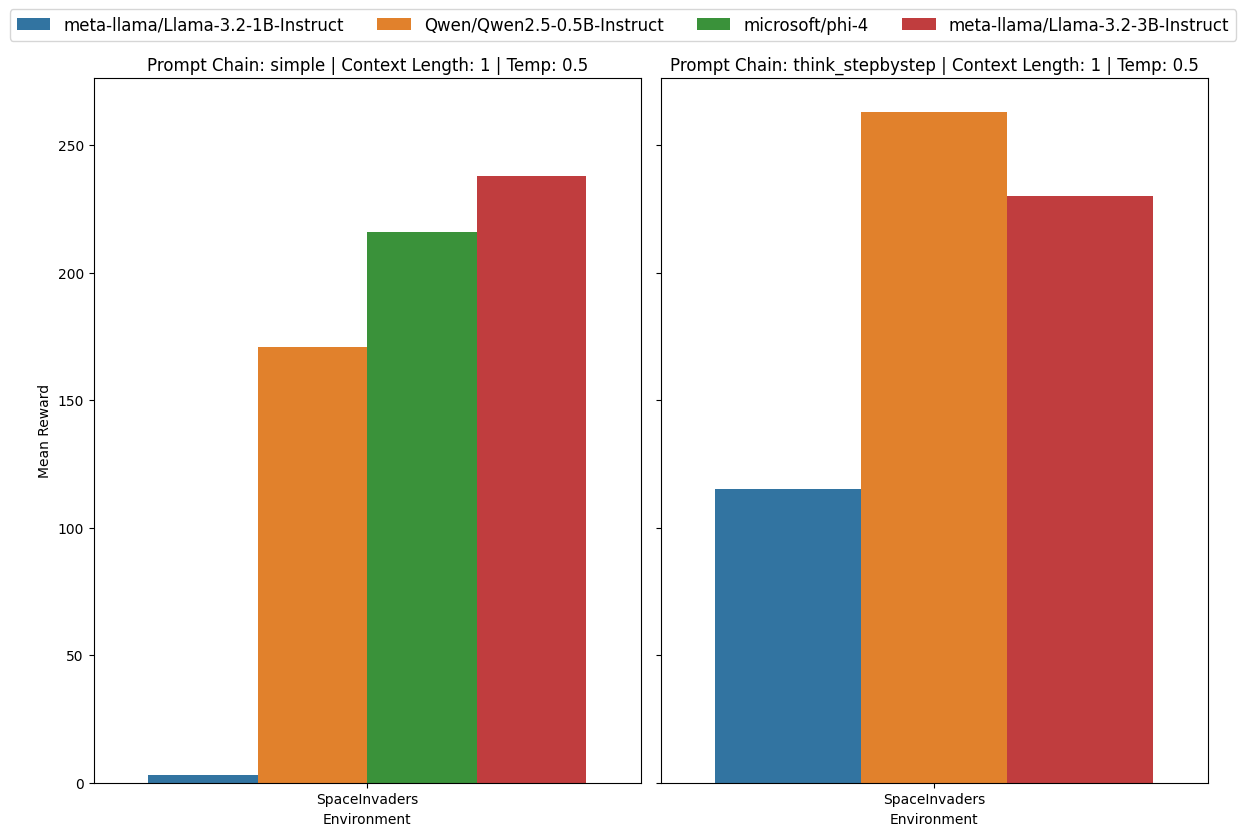

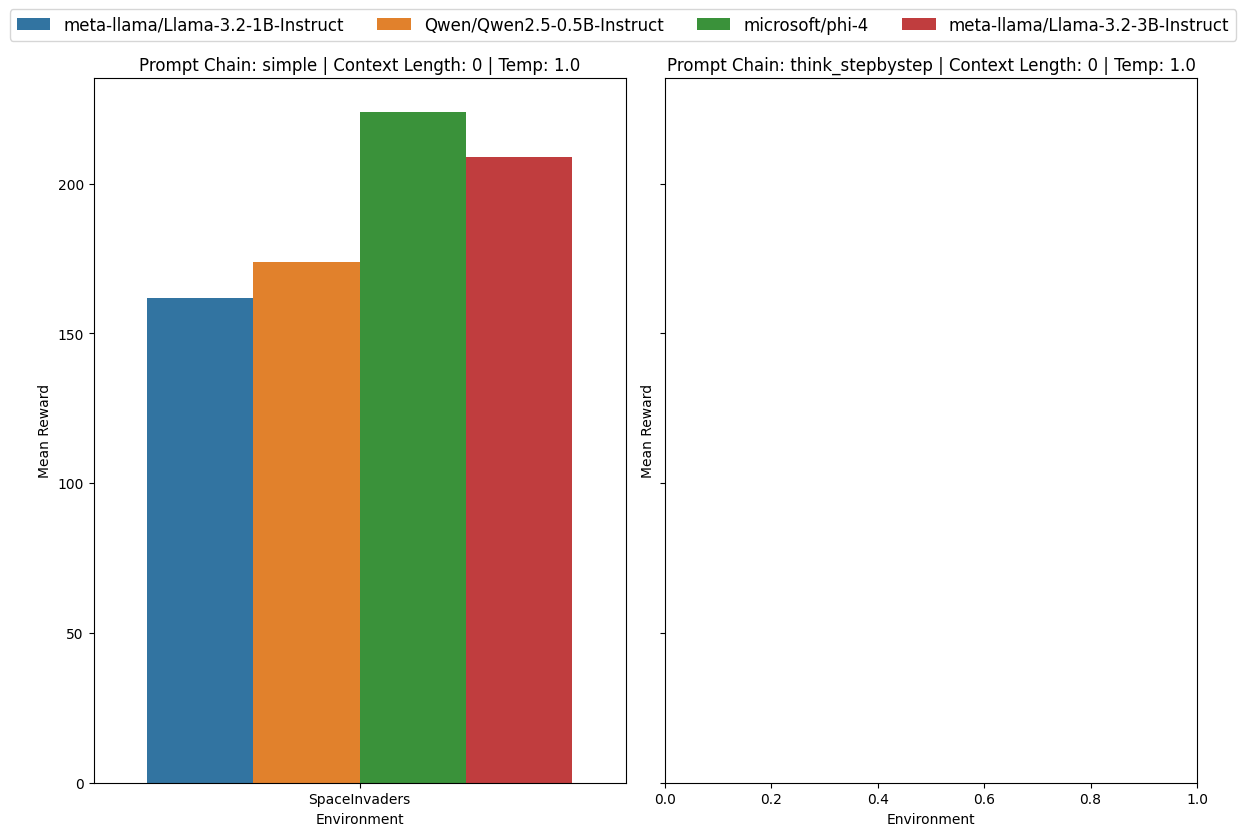

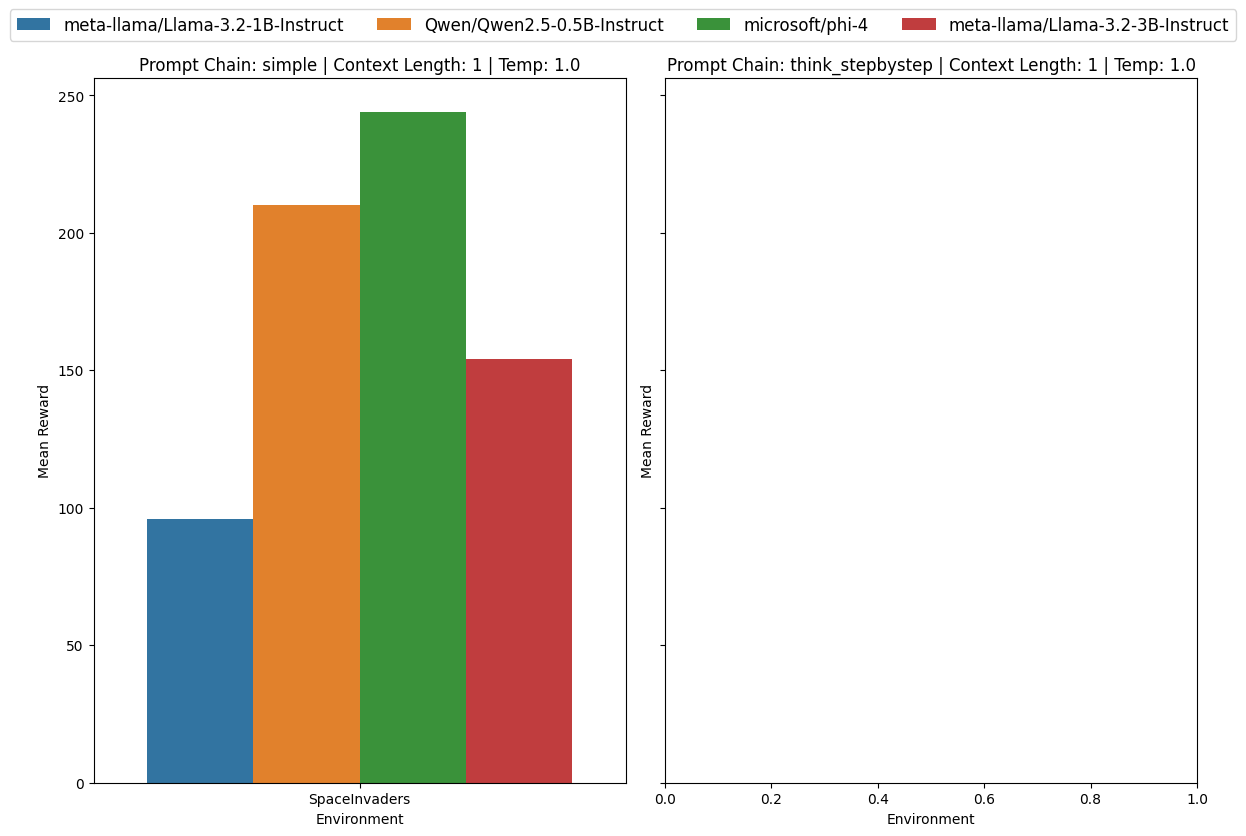

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a color palette based on unique model names
unique_models = df['model_name'].unique()
palette = dict(zip(unique_models, sns.color_palette("tab10", len(unique_models))))

# Get unique values
unique_prompt_chains = df['prompt_chain'].unique()
unique_context_lengths = df['context_length'].unique()
unique_temperatures = df['temperature'].unique()

for temp in unique_temperatures:
    df_temp = df[df['temperature'] == temp]
    
    for context_len in unique_context_lengths:
        df_context = df_temp[df_temp['context_length'] == context_len]
        
        fig, axs = plt.subplots(1, len(unique_prompt_chains), figsize=(12, 8), sharey=True)
        
        if not isinstance(axs, np.ndarray):
            axs = [axs]
        
        for i, prompt_chain in enumerate(unique_prompt_chains):
            df_ = df_context[df_context['prompt_chain'] == prompt_chain]
            df_['mean_reward'] = df_['mean_reward'].replace(0, 1)
            
            sns.barplot(x='env_id', y='mean_reward', data=df_, hue='model_name', ax=axs[i], palette=palette)
            axs[i].set_title(f"Prompt Chain: {prompt_chain} | Context Length: {context_len} | Temp: {temp}")
            axs[i].set_ylabel('Mean Reward')
            axs[i].set_xlabel('Environment')
            
            # Remove individual subplot legends
            try:
                axs[i].legend_.remove()
            except:
                continue
        
        # Create a single shared legend
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', ncol=len(unique_models), bbox_to_anchor=(0.5, 1.05), fontsize='large')
        
        plt.tight_layout()
        plt.show()
